<a href="https://colab.research.google.com/github/igumiao/nlp_G60/blob/xiaohong/Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# 1. DataSet Processing

# Import necessary libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F


# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# --- Configuration ---
DRIVE_DATA_PATH = '/content/drive/MyDrive/data'  # Path to the data directory

# Set device to GPU if available, otherwise CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

# File paths
TRAIN_CLAIMS_PATH = os.path.join(DRIVE_DATA_PATH, 'train-claims.json')
DEV_CLAIMS_PATH = os.path.join(DRIVE_DATA_PATH, 'dev-claims.json')
TEST_CLAIMS_PATH = os.path.join(DRIVE_DATA_PATH, 'test-claims-unlabelled.json')
EVIDENCE_PATH = os.path.join(DRIVE_DATA_PATH, 'evidence.json')
# DEV_PREDICTIONS_PATH = os.path.join(DRIVE_DATA_PATH, 'dev-claims-predictions.json')
DEV_PREDICTIONS_PATH = os.path.join(DRIVE_DATA_PATH, 'mixedAndWeight-predictions.json')
TEST_PREDICTIONS_PATH = os.path.join(DRIVE_DATA_PATH, 'test-claims-predictions.json')
EVAL_SCRIPT_PATH = os.path.join('eval.py')

# --- Helper Functions ---
def load_json(filepath):
    """Loads JSON data from a file."""
    print(f"Loading {filepath}...")
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} items.")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Could not decode JSON from {filepath}. Error: {e}")
        return None

def preprocess_text(text, remove_stop_words=False, lemmatize=False, stem=False):
    """
    Preprocess text with multiple options:
    - Lowercase
    - Remove special characters
    - Optional: Remove stopwords
    - Optional: Lemmatization
    - Optional: Stemming
    """
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and extra spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords if requested
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

    # Apply lemmatization if requested
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Apply stemming if requested
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]

    # Join the tokens back to a string
    processed_text = ' '.join(tokens)

    return processed_text

def basic_dataset_analysis(data_dict, name):
    """Basic analysis of a dataset (claims or evidence)."""
    print(f"\n=== Basic Analysis of {name} Dataset ===")
    print(f"Number of items: {len(data_dict)}")

    # For claims, check label distribution
    if name == 'Claims' and 'claim_label' in next(iter(data_dict.values())):
        labels = [item.get('claim_label') for item in data_dict.values() if 'claim_label' in item]
        label_counts = Counter(labels)
        print("\nLabel Distribution:")
        for label, count in label_counts.items():
            print(f"  {label}: {count} ({count/len(labels)*100:.2f}%)")

    # Check text lengths
    if 'claim_text' in next(iter(data_dict.values()), {}):
        # For claims
        text_field = 'claim_text'
        text_lengths = [len(item[text_field].split()) for item in data_dict.values()]
    else:
        # For evidence
        text_lengths = [len(text.split()) for i, text in enumerate(data_dict.values()) if i < 1000]
        text_field = 'evidence text'

    print(f"\n{text_field.capitalize()} Length Statistics (in words):")
    print(f"  Average length: {sum(text_lengths)/len(text_lengths):.2f}")
    print(f"  Maximum length: {max(text_lengths)}")
    print(f"  Minimum length: {min(text_lengths)}")

    return text_lengths

# --- 1. Load and Explore Datasets ---
train_claims = load_json(TRAIN_CLAIMS_PATH)
dev_claims = load_json(DEV_CLAIMS_PATH)
test_claims = load_json(TEST_CLAIMS_PATH)
evidence = load_json(EVIDENCE_PATH)

# Print a sample claim to understand structure
print("\n=== Sample Data Structure ===")
sample_claim_id = next(iter(train_claims))
print(f"Sample claim ID: {sample_claim_id}")
print(json.dumps(train_claims[sample_claim_id], indent=2))

# Print a sample evidence
sample_evidence_id = next(iter(evidence))
print(f"\nSample evidence ID: {sample_evidence_id}")
print(f"Evidence text: {evidence[sample_evidence_id]}")

# # --- 2. Basic Dataset Analysis ---
# train_lengths = basic_dataset_analysis(train_claims, "Training Claims")
# dev_lengths = basic_dataset_analysis(dev_claims, "Development Claims")
# test_lengths = basic_dataset_analysis(test_claims, "Test Claims")

# # Sample evidence for analysis (avoid analyzing all 1.2M items)
# sample_evidence = {k: evidence[k] for k in list(evidence.keys())[:1000]}
# evidence_lengths = basic_dataset_analysis(sample_evidence, "Evidence (Sample)")

# # --- 3. Create a simple visualization ---
# plt.figure(figsize=(10, 6))
# plt.hist(train_lengths, bins=30, alpha=0.5, label='Claims')
# plt.hist(evidence_lengths, bins=30, alpha=0.5, label='Evidence')
# plt.xlabel('Word Count')
# plt.ylabel('Frequency')
# plt.title('Distribution of Text Lengths: Claims vs Evidence')
# plt.legend()
# plt.tight_layout()
# plt.savefig('text_length_distribution.png')
# plt.show()

# # --- 4. Preprocessing Examples ---
# print("\n=== Preprocessing Examples ===")

# Sample a claim
sample_claim = train_claims[sample_claim_id]['claim_text']
print(f"Original claim: {sample_claim}")
print(f"Basic preprocessing: {preprocess_text(sample_claim)}")
print(f"With stopword removal: {preprocess_text(sample_claim, remove_stop_words=True)}")
print(f"With lemmatization: {preprocess_text(sample_claim, lemmatize=True)}")
print(f"With stemming: {preprocess_text(sample_claim, stem=True)}")

# Sample an evidence
sample_evidence_text = evidence[sample_evidence_id]
print(f"\nOriginal evidence: {sample_evidence_text}")
print(f"Basic preprocessing: {preprocess_text(sample_evidence_text)}")
print(f"With stopword removal: {preprocess_text(sample_evidence_text, remove_stop_words=True)}")

print("\nData processing complete!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Using GPU: Tesla T4
Loading /content/drive/MyDrive/data/train-claims.json...
Successfully loaded 1228 items.
Loading /content/drive/MyDrive/data/dev-claims.json...
Successfully loaded 154 items.
Loading /content/drive/MyDrive/data/test-claims-unlabelled.json...
Successfully loaded 153 items.
Loading /content/drive/MyDrive/data/evidence.json...
Successfully loaded 1208827 items.

=== Sample Data Structure ===
Sample claim ID: claim-1937
{
  "claim_text": "Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.",
  "claim_label": "DISPUTED",
  "evidences": [
    "evidence-442946",
    "evidence-1194317",
    "evidence-12171"
  ]
}

Sample evidence ID: evidence-0
Evidence text: John Bennet Lawes, English entrepreneur and agricultural scientist
Original claim: Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant 

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [3]:
# --- Global Configuration Variables ---
# TF-IDF settings
TFIDF_MAX_FEATURES = 20000
TFIDF_TOP_K = 500

# Model settings
TRANSFORMER_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
TRANSFORMER_BATCH_SIZE = 32
TRANSFORMER_MAX_LENGTH = 512

# Retrieval settings
EVIDENCE_FINAL_TOP_K = 4  # The value to use for evidence retrieval
EXPERIMENT_WITH_MULTIPLE_K = False  # Set to True to experiment with different k values
EVIDENCE_TOP_K_VALUES = [3, 4, 5 ,6] if EXPERIMENT_WITH_MULTIPLE_K else [EVIDENCE_FINAL_TOP_K]

# Memory management
CUDA_CACHE_CLEAR_FREQUENCY = 20  # Clear CUDA cache every N claims
PROGRESS_REPORT_FREQUENCY = 50  # Report progress every N claims

# Text Processing settings
REMOVE_STOP_WORDS = False
LEMMATIZE = True

import gc

#### Retrieval

In [4]:

# --- Hugging Face Embedder Class ---
class HuggingFaceEmbedder:
    def __init__(self, model_name=TRANSFORMER_MODEL_NAME):
        """
        Initialize the Hugging Face embedder.
        """
        print(f"Loading model {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        # Move model to GPU if available
        self.device = device
        self.model.to(self.device)
        self.model.eval()  # Set model to evaluation mode

    def mean_pooling(self, model_output, attention_mask):
        """
        Perform mean pooling on model outputs using attention mask.
        """
        # Mean pooling - take average of all token embeddings
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def encode(self, texts, batch_size=TRANSFORMER_BATCH_SIZE, show_progress=False):
        """
        Encode texts to embeddings using the model.
        """
        all_embeddings = []

        # Process texts in batches
        iterator = range(0, len(texts), batch_size)
        if show_progress:
            iterator = tqdm(iterator, desc="Encoding texts")

        for i in iterator:
            batch_texts = texts[i:i+batch_size]

            # Tokenize
            encoded_input = self.tokenizer(batch_texts, padding=True, truncation=True,
                                          max_length=TRANSFORMER_MAX_LENGTH, return_tensors='pt')

            # Move to device
            encoded_input = {k: v.to(self.device) for k, v in encoded_input.items()}

            # Get model output
            with torch.no_grad():
                outputs = self.model(**encoded_input)

            # Perform pooling and get embeddings
            batch_embeddings = self.mean_pooling(outputs, encoded_input['attention_mask'])

            # Normalize embeddings
            batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)

            # Move to CPU to free up GPU memory
            all_embeddings.append(batch_embeddings.cpu())

        # Concatenate all embeddings
        if len(all_embeddings) > 0:
            all_embeddings = torch.cat(all_embeddings, dim=0)

        return all_embeddings



#### Two-Stage Retriever

In [5]:

# --- Two-Stage Retriever Class ---
class TwoStageRetriever:
    def __init__(self, evidence_corpus, tfidf_preprocessing=None, model_name=TRANSFORMER_MODEL_NAME):
        """
        Initialize the two-stage retriever with TF-IDF and Hugging Face Transformers.

        Args:
            evidence_corpus (dict): Dictionary of evidence texts
            tfidf_preprocessing (function, optional): Function to preprocess text for TF-IDF
            model_name (str): Name of the Hugging Face model to use
        """
        self.evidence_corpus = evidence_corpus
        self.evidence_ids = list(evidence_corpus.keys())
        self.tfidf_preprocessing = tfidf_preprocessing if tfidf_preprocessing else preprocess_text

        # Prepare evidence texts for TF-IDF
        print("Preparing evidence texts for TF-IDF...")
        start_time = time.time()
        self.evidence_texts = [self.tfidf_preprocessing(evidence_corpus[eid]) for eid in tqdm(self.evidence_ids)]
        print(f"Evidence preparation took {time.time() - start_time:.2f} seconds")

        # Initialize TF-IDF vectorizer
        print("Fitting TF-IDF vectorizer...")
        start_time = time.time()
        self.tfidf_vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES)
        self.tfidf_evidence_matrix = self.tfidf_vectorizer.fit_transform(self.evidence_texts)
        print(f"TF-IDF fitting took {time.time() - start_time:.2f} seconds")

        # Initialize Hugging Face embedder
        self.embedder = HuggingFaceEmbedder(model_name)

        print("Two-stage retriever initialized successfully.")

    def retrieve(self, claim, tfidf_top_k=TFIDF_TOP_K, final_top_k=EVIDENCE_FINAL_TOP_K):
        """
        Retrieve evidence for a claim using the two-stage approach.

        Args:
            claim (str): The claim text
            tfidf_top_k (int): Number of candidates to retrieve with TF-IDF
            final_top_k (int): Number of final candidates to return after re-ranking

        Returns:
            list: Top k evidence IDs
            list: Corresponding similarity scores
        """
        # Stage 1: TF-IDF retrieval
        processed_claim = self.tfidf_preprocessing(claim)
        claim_vector = self.tfidf_vectorizer.transform([processed_claim])

        # Calculate cosine similarity with all evidence
        tfidf_similarities = cosine_similarity(claim_vector, self.tfidf_evidence_matrix)[0]

        # Get top-k candidate indices
        tfidf_top_indices = np.argsort(-tfidf_similarities)[:tfidf_top_k]
        tfidf_top_evidence_ids = [self.evidence_ids[idx] for idx in tfidf_top_indices]
        tfidf_top_evidence_texts = [self.evidence_corpus[eid] for eid in tfidf_top_evidence_ids]

        # Stage 2: Transformer embedding re-ranking
        # Encode claim and candidates
        with torch.no_grad():
            claim_embedding = self.embedder.encode([claim])
            candidate_embeddings = self.embedder.encode(tfidf_top_evidence_texts)

        # Calculate similarities
        similarities = torch.matmul(candidate_embeddings, claim_embedding.t()).squeeze()

        # Get top-k final indices
        top_k_indices = torch.argsort(similarities, descending=True)[:final_top_k].tolist()

        # Get final evidence IDs and scores
        final_evidence_ids = [tfidf_top_evidence_ids[idx] for idx in top_k_indices]
        final_scores = [similarities[idx].item() for idx in top_k_indices]

        return final_evidence_ids, final_scores

    def batch_retrieve(self, claims_dict, tfidf_top_k=TFIDF_TOP_K, final_top_k=EVIDENCE_FINAL_TOP_K):
        """
        Retrieve evidence for multiple claims in batch mode.

        Args:
            claims_dict (dict): Dictionary of claims
            tfidf_top_k (int): Number of candidates to retrieve with TF-IDF
            final_top_k (int): Number of final candidates to return after re-ranking

        Returns:
            dict: Dictionary mapping claim IDs to lists of evidence IDs
        """
        results = {}
        total_claims = len(claims_dict)

        print(f"Processing {total_claims} claims...")
        start_time = time.time()

        for idx, (claim_id, claim_data) in enumerate(tqdm(claims_dict.items())):
            claim_text = claim_data['claim_text']
            evidence_ids, _ = self.retrieve(claim_text, tfidf_top_k, final_top_k)
            results[claim_id] = evidence_ids

            # # Periodically clear CUDA cache to prevent memory leaks
            # if torch.cuda.is_available() and (idx % CUDA_CACHE_CLEAR_FREQUENCY == 0):
            #     torch.cuda.empty_cache()
            #     gc.collect()

            # Periodically report progress
            if (idx + 1) % PROGRESS_REPORT_FREQUENCY == 0 or (idx + 1) == total_claims:
                elapsed = time.time() - start_time
                claims_per_second = (idx + 1) / elapsed
                print(f"Processed {idx + 1}/{total_claims} claims "
                      f"({(idx + 1)/total_claims*100:.1f}%) "
                      f"at {claims_per_second:.2f} claims/second")

        total_time = time.time() - start_time
        print(f"Total retrieval time: {total_time:.2f} seconds "
              f"({total_time/60:.2f} minutes)")

        return results

def evaluate_retrieval_fscore(retrieved_evidences, groundtruth_claims):
    """
    Calculate F-score for evidence retrieval.
    """
    f_scores = []

    for claim_id, claim_data in groundtruth_claims.items():
        if claim_id in retrieved_evidences:
            # Get retrieved and ground truth evidence sets
            retrieved_set = set(retrieved_evidences[claim_id])
            groundtruth_set = set(claim_data["evidences"])

            # Calculate number of correct retrievals
            correct = len(retrieved_set.intersection(groundtruth_set))

            # Calculate precision, recall, and F-score
            precision = correct / len(retrieved_set) if len(retrieved_set) > 0 else 0
            recall = correct / len(groundtruth_set) if len(groundtruth_set) > 0 else 0

            # Calculate F-score
            fscore = 0
            if precision > 0 and recall > 0:
                fscore = 2 * precision * recall / (precision + recall)

            f_scores.append(fscore)

    # Return average F-score
    return np.mean(f_scores) if f_scores else 0.0


In [6]:
# --- Main Retrieval Function ---
def run_evidence_retrieval(train_claims, dev_claims, test_claims, evidence):
    """
    Run the evidence retrieval pipeline and evaluate results.
    """
    print("\n=== Retrieval Hyperparameters ===")
    print(f"TFIDF_MAX_FEATURES: {TFIDF_MAX_FEATURES}")
    print(f"TFIDF_TOP_K: {TFIDF_TOP_K}")
    print(f"TRANSFORMER_MODEL: {TRANSFORMER_MODEL_NAME}")
    print(f"EVIDENCE_TOP_K_VALUES: {EVIDENCE_TOP_K_VALUES}")

    # Use your existing preprocessing function
    def preprocess_for_retrieval(text):
        return preprocess_text(text, remove_stop_words=REMOVE_STOP_WORDS, lemmatize=LEMMATIZE)

    # Results container
    all_results = {}

    # Initialize the retriever (only once)
    print("Initializing two-stage retriever...")
    start_time = time.time()
    retriever = TwoStageRetriever(
        evidence_corpus=evidence,
        tfidf_preprocessing=preprocess_for_retrieval,
        model_name=TRANSFORMER_MODEL_NAME
    )
    print(f"Retriever initialization took {time.time() - start_time:.2f} seconds")

    # Run only with selected top_k value(s)
    for top_k in EVIDENCE_TOP_K_VALUES:
        print(f"\n--- Evidence Retrieval with Top-K = {top_k} ---")

        # Retrieve evidence for dev set
        print(f"Retrieving evidence for development set...")
        dev_evidence_results = retriever.batch_retrieve(
            dev_claims,
            tfidf_top_k=TFIDF_TOP_K,
            final_top_k=top_k
        )

        # Create dev predictions format
        dev_predictions = {}
        for claim_id, claim_data in dev_claims.items():
            dev_predictions[claim_id] = {
                "claim_text": claim_data["claim_text"],
                "claim_label": claim_data["claim_label"],
                "evidences": dev_evidence_results[claim_id]
            }

        # Save dev predictions
        dev_predictions_path = DEV_PREDICTIONS_PATH
        if EXPERIMENT_WITH_MULTIPLE_K:
            # If experimenting, save with specific filename
            dev_predictions_path = os.path.join(DRIVE_DATA_PATH, f'dev-claims-predictions-top{top_k}.json')

        print(f"Saving development predictions to {dev_predictions_path}")
        with open(dev_predictions_path, 'w') as f:
            json.dump(dev_predictions, f, indent=2)

        # # Evaluate dev results
        print(f"Evaluating development results...")
        fscore = evaluate_retrieval_fscore(dev_evidence_results, dev_claims)
        print(f"Evidence Retrieval F-score = {fscore:.4f}")

        # Store results
        all_results[f"dev_top{top_k}"] = dev_evidence_results

        # Also retrieve for test set if this is the final top_k
        if top_k == EVIDENCE_FINAL_TOP_K or not EXPERIMENT_WITH_MULTIPLE_K:
            print(f"\nRetrieving evidence for test set...")
            test_evidence_results = retriever.batch_retrieve(
                test_claims,
                tfidf_top_k=TFIDF_TOP_K,
                final_top_k=top_k
            )

            # Create test predictions
            test_predictions = {}
            for claim_id, claim_data in test_claims.items():
                test_predictions[claim_id] = {
                    "claim_text": claim_data["claim_text"],
                    "claim_label": None,  # Will be filled by classification
                    "evidences": test_evidence_results[claim_id]
                }

            # Save test predictions
            print(f"Saving test predictions to {TEST_PREDICTIONS_PATH}")
            with open(TEST_PREDICTIONS_PATH, 'w') as f:
                json.dump(test_predictions, f, indent=2)

            all_results["test"] = test_evidence_results

    all_results["retriever"] = retriever
    print("\nEvidence retrieval completed!")
    return all_results

In [7]:
# --- 5. Run Evidence Retrieval Pipeline ---
print("\n=== Running Evidence Retrieval Pipeline ===")

# Check if retrieval results already exist to avoid recomputation
retrieval_results_path = os.path.join(DRIVE_DATA_PATH, 'retrieval_results.pt')

if os.path.exists(retrieval_results_path) and False:  # Set to True to use cached results
    print(f"Loading cached retrieval results from {retrieval_results_path}")
    retrieval_results = torch.load(retrieval_results_path,weights_only=True)
    print("Loaded retrieval results successfully.")
else:
    print("Running evidence retrieval pipeline...")
    retrieval_results = run_evidence_retrieval(
        train_claims=train_claims,
        dev_claims=dev_claims,
        test_claims=test_claims,
        evidence=evidence
    )

    # Save retrieval results (excluding the retriever object which might be large)
    results_to_save = {k: v for k, v in retrieval_results.items() if k != 'retriever'}
    print(f"Saving retrieval results to {retrieval_results_path}")
    torch.save(results_to_save, retrieval_results_path)

print("\nEvidence retrieval step completed!")


=== Running Evidence Retrieval Pipeline ===
Running evidence retrieval pipeline...

=== Retrieval Hyperparameters ===
TFIDF_MAX_FEATURES: 20000
TFIDF_TOP_K: 500
TRANSFORMER_MODEL: sentence-transformers/all-MiniLM-L6-v2
EVIDENCE_TOP_K_VALUES: [4]
Initializing two-stage retriever...
Preparing evidence texts for TF-IDF...


100%|██████████| 1208827/1208827 [04:07<00:00, 4892.74it/s]


Evidence preparation took 247.07 seconds
Fitting TF-IDF vectorizer...
TF-IDF fitting took 21.40 seconds
Loading model sentence-transformers/all-MiniLM-L6-v2...


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Two-stage retriever initialized successfully.
Retriever initialization took 280.32 seconds

--- Evidence Retrieval with Top-K = 4 ---
Retrieving evidence for development set...
Processing 154 claims...


 32%|███▏      | 50/154 [00:46<01:37,  1.07it/s]

Processed 50/154 claims (32.5%) at 1.08 claims/second


 65%|██████▍   | 100/154 [01:31<00:47,  1.13it/s]

Processed 100/154 claims (64.9%) at 1.09 claims/second


 97%|█████████▋| 150/154 [02:17<00:03,  1.06it/s]

Processed 150/154 claims (97.4%) at 1.09 claims/second


100%|██████████| 154/154 [02:20<00:00,  1.09it/s]

Processed 154/154 claims (100.0%) at 1.09 claims/second
Total retrieval time: 140.96 seconds (2.35 minutes)
Saving development predictions to /content/drive/MyDrive/data/mixedAndWeight-predictions.json


Evaluating development results...
Evidence Retrieval F-score = 0.1734

Retrieving evidence for test set...
Processing 153 claims...


 33%|███▎      | 50/153 [00:45<01:34,  1.09it/s]

Processed 50/153 claims (32.7%) at 1.10 claims/second


 65%|██████▌   | 100/153 [01:30<00:47,  1.11it/s]

Processed 100/153 claims (65.4%) at 1.11 claims/second


 98%|█████████▊| 150/153 [02:15<00:02,  1.15it/s]

Processed 150/153 claims (98.0%) at 1.11 claims/second


100%|██████████| 153/153 [02:18<00:00,  1.11it/s]

Processed 153/153 claims (100.0%) at 1.11 claims/second
Total retrieval time: 138.37 seconds (2.31 minutes)
Saving test predictions to /content/drive/MyDrive/data/test-claims-predictions.json



Evidence retrieval completed!
Saving retrieval results to /content/drive/MyDrive/data/retrieval_results.pt

Evidence retrieval step completed!


#### Classification with "distilbert-base-uncased"

Configuration

In [8]:
# --- Task 2: Claim Verification Configuration ---
# Model settings
VERIFICATION_MODEL_NAME = "distilbert-base-uncased"
VERIFICATION_BATCH_SIZE = 16
VERIFICATION_MAX_LENGTH = 512
VERIFICATION_LEARNING_RATE = 1e-5
VERIFICATION_NUM_EPOCHS = 6
VERIFICATION_NUM_LABELS = 4

# Class management
USE_CLASS_WEIGHTS = True
USE_MIXED_EVIDENCE = True  # Whether to use both gold and retrieved evidence
MIX_RATIO=0.5  # Ratio of gold evidence to retrieved evidence

# Training phases
PHASE1_MODEL_PATH = os.path.join(DRIVE_DATA_PATH, 'verification_model_phase1.pt')
PHASE2_MODEL_PATH = os.path.join(DRIVE_DATA_PATH, 'verification_model_phase2.pt')
FINAL_MODEL_PATH = os.path.join(DRIVE_DATA_PATH, 'verification_model_final.pt')

# Label mapping
LABEL_MAP = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT_ENOUGH_INFO": 2,
    "DISPUTED": 3
}
LABEL_MAP_REVERSE = {v: k for k, v in LABEL_MAP.items()}

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [9]:
import random


def prepare_input_sequence(
    claim, evidence, tokenizer, max_length=VERIFICATION_MAX_LENGTH
):
    """
    Prepare input sequence for the model by tokenizing and formatting claim + evidence.
    Implements smart truncation to handle long evidence passages.
    """
    # Tokenize the claim and evidence pair
    if "distilbert" in VERIFICATION_MODEL_NAME.lower():
        encoded = tokenizer.encode_plus(
            text=claim,
            text_pair=evidence,
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors=None,  # Return Python lists
            return_attention_mask=True,
            return_token_type_ids=False,  # No token_type_ids for DistilBERT
        )
    else:
        encoded = tokenizer.encode_plus(
            text=claim,
            text_pair=evidence,
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors=None,  # Return Python lists
            return_attention_mask=True,
            return_token_type_ids=True,
        )

    return encoded


class ClaimVerificationDataset(Dataset):
    def __init__(
        self,
        claims,
        evidence,
        tokenizer,
        max_length=VERIFICATION_MAX_LENGTH,
        use_ground_truth=True,
        retrieved_evidence=None,
        mix_ratio=0.0,
    ):
        """
        Dataset for claim verification.

        Args:
            claims: Dictionary of claims
            evidence: Dictionary of evidence passages
            tokenizer: Tokenizer for preprocessing
            max_length: Maximum sequence length
            use_ground_truth: Whether to use ground truth evidence
            retrieved_evidence: Dictionary of retrieved evidence IDs (from Task 1)
            mix_ratio: Ratio of retrieved evidence to mix in (0.0-1.0)
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = []

        print(
            f"Creating dataset (use_ground_truth={use_ground_truth}, mix_ratio={mix_ratio})..."
        )

        # Set random seed for reproducibility when mixing evidence
        random.seed(42)

        # Process each claim
        for claim_id, claim_data in tqdm(claims.items(), desc="Processing claims"):
            claim_text = claim_data["claim_text"]

            # Skip claims without labels (e.g., test set)
            if "claim_label" not in claim_data:
                continue

            label = LABEL_MAP.get(claim_data["claim_label"])

            # Use ground truth evidence if available and requested
            if use_ground_truth and "evidences" in claim_data:
                for ev_id in claim_data["evidences"]:
                    if ev_id in evidence:
                        self.samples.append(
                            {
                                "claim_id": claim_id,
                                "claim_text": claim_text,
                                "evidence_id": ev_id,
                                "evidence_text": evidence[ev_id],
                                "label": label,
                                "is_ground_truth": True,
                            }
                        )

            # Mix in retrieved evidence if requested
            if retrieved_evidence and claim_id in retrieved_evidence and mix_ratio > 0:
                for ev_id in retrieved_evidence[claim_id]:
                    # Skip if already included as ground truth
                    if (
                        use_ground_truth
                        and "evidences" in claim_data
                        and ev_id in claim_data["evidences"]
                    ):
                        continue

                    # Only include with probability equal to mix_ratio
                    if random.random() < mix_ratio and ev_id in evidence:
                        self.samples.append(
                            {
                                "claim_id": claim_id,
                                "claim_text": claim_text,
                                "evidence_id": ev_id,
                                "evidence_text": evidence[ev_id],
                                "label": label,
                                "is_ground_truth": False,
                            }
                        )

        print(f"Created dataset with {len(self.samples)} samples")

        # Print ground truth vs retrieved evidence statistics
        ground_truth_count = sum(
            1 for sample in self.samples if sample["is_ground_truth"]
        )
        retrieved_count = len(self.samples) - ground_truth_count
        print(f"Ground truth evidence: {ground_truth_count}")
        print(f"Retrieved evidence: {retrieved_count}")
        print(f"Ratio of retrieved to total: {retrieved_count/len(self.samples):.2f}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Tokenize and prepare input sequence
        encoded = prepare_input_sequence(
            sample["claim_text"],
            sample["evidence_text"],
            self.tokenizer,
            self.max_length,
        )

        # Convert to tensors
        item = {
            "input_ids": torch.tensor(encoded["input_ids"]),
            "attention_mask": torch.tensor(encoded["attention_mask"]),
            "label": torch.tensor(sample["label"]),
        }

        # Add token_type_ids only if not using DistilBERT
        if "token_type_ids" in encoded:
            item["token_type_ids"] = torch.tensor(encoded["token_type_ids"])

        return item

In [10]:
class ClaimVerificationModel(nn.Module):
    def __init__(self, num_labels=VERIFICATION_NUM_LABELS, model_name=VERIFICATION_MODEL_NAME):
        """
        Transformer-based model for claim verification.
        """
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)
        self.evidence_attention = nn.Linear(self.transformer.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        """
        Forward pass through the model.

        Args:
            input_ids: Token IDs
            attention_mask: Attention mask
            token_type_ids: Optional token type IDs
            labels: Optional labels for loss calculation

        Returns:
            If labels provided: (loss, logits)
            If labels not provided: logits
        """


        if 'distilbert' in VERIFICATION_MODEL_NAME.lower():
            outputs = self.transformer(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        else:
            outputs = self.transformer(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
        # Get CLS token representation
        cls_output = outputs[0][:, 0, :]  # CLS token output
        # Calculate attention scores - apply consistently regardless of training mode
        attention_scores = self.evidence_attention(cls_output)
        # Apply the attention as a weighting factor
        cls_output = cls_output * torch.sigmoid(attention_scores)

        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return (loss, logits) if loss is not None else logits

    def get_attention_score(self, cls_output):
        """Calculate attention score for evidence weighting"""
        return torch.sigmoid(self.evidence_attention(cls_output))

    def predict_with_evidence_set(self, claim_text, evidence_texts, tokenizer):
        """
        Process multiple evidence passages for one claim and make a prediction.

        Args:
            claim_text: The claim text
            evidence_texts: List of evidence texts
            tokenizer: Tokenizer for encoding

        Returns:
            Probability distribution over the 4 classes
        """
        self.eval()
        all_logits = []
        all_attention = []

        # Default if no evidence
        if not evidence_texts:
            print(f"No evidence passages provided.")
            return torch.tensor([0, 0, 1, 0], device=device)  # Default to NOT_ENOUGH_INFO

        # Process each evidence passage
        for evidence_text in evidence_texts:
            # Prepare input
            encoded = prepare_input_sequence(claim_text, evidence_text, tokenizer, VERIFICATION_MAX_LENGTH)
            input_ids = torch.tensor([encoded["input_ids"]]).to(device)
            attention_mask = torch.tensor([encoded["attention_mask"]]).to(device)

            # Get predictions
            with torch.no_grad():
                if 'distilbert' in VERIFICATION_MODEL_NAME.lower():
                    outputs = self.transformer(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    )
                else:
                    token_type_ids = torch.tensor([encoded["token_type_ids"]]).to(device) if "token_type_ids" in encoded else None
                    outputs = self.transformer(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids
                    )

                cls_output = outputs[0][:, 0, :]

                # Get attention score
                attention_score = self.get_attention_score(cls_output)

                # Get logits
                logits = self.classifier(self.dropout(cls_output))

                all_logits.append(logits)
                all_attention.append(attention_score)

        # Stack results
        stacked_logits = torch.cat(all_logits, dim=0)
        stacked_attention = torch.cat(all_attention, dim=0)



        # Normalize attention
        norm_attention = F.softmax(stacked_attention.squeeze(-1), dim=0)

        # Weighted average of logits
        weighted_logits = torch.sum(stacked_logits * norm_attention.unsqueeze(-1), dim=0)

        # Return probabilities
        return F.softmax(weighted_logits, dim=0)

In [11]:
import seaborn as sns
def get_loss_function(labels=None, use_class_weights=False):
    """Get loss function with optional class weighting."""
    if use_class_weights and labels is not None:
        # Calculate class weights
        class_counts = torch.bincount(labels)
        class_weights = len(labels) / (len(class_counts) * class_counts)
        class_weights = class_weights.to(device)

        print(f"Using class weights: {class_weights}")
        return nn.CrossEntropyLoss(weight=class_weights)
    else:
        return nn.CrossEntropyLoss()

def train_epoch(model, dataloader, optimizer, scheduler=None):
    """Train for one epoch."""
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        # Forward pass
        if 'token_type_ids' in batch and 'distilbert' not in VERIFICATION_MODEL_NAME.lower():
            loss, logits = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch["token_type_ids"],
                labels=batch["label"]
            )
        else:
            loss, logits = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["label"]
            )

        # Backward pass
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    """Evaluate the model on a dataset."""
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            if 'token_type_ids' in batch and 'distilbert' not in VERIFICATION_MODEL_NAME.lower():
                loss, logits = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    token_type_ids=batch["token_type_ids"],
                    labels=batch["label"]
                )
            else:
                loss, logits = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["label"]
                )

            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch["label"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calculate metrics
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, balanced_accuracy_score
    accuracy = accuracy_score(all_labels, all_preds)

    # Option 2: Calculate F1 score (macro-averaged)
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Option 3: Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    report = classification_report(all_labels, all_preds, target_names=list(LABEL_MAP.keys()), output_dict=True)

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return {
        "loss": total_loss / len(dataloader),
        "accuracy": accuracy,
        "f1_score": f1,  # Added F1 score
        "balanced_accuracy": balanced_acc,  # Added balanced accuracy
        "report": report,
        "confusion_matrix": cm
    }

def train_model(model, train_dataset, val_dataset, num_epochs=VERIFICATION_NUM_EPOCHS,
                batch_size=VERIFICATION_BATCH_SIZE, learning_rate=VERIFICATION_LEARNING_RATE,
                use_class_weights=USE_CLASS_WEIGHTS, save_path=FINAL_MODEL_PATH):
    """
    Train the claim verification model.

    Args:
        model: The model to train
        train_dataset: Training dataset
        val_dataset: Validation dataset
        num_epochs: Number of training epochs
        batch_size: Batch size
        learning_rate: Learning rate
        use_class_weights: Whether to use class weighting
        save_path: Path to save the best model

    Returns:
        The trained model and evaluation metrics
    """
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Setup optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Get loss function
    if use_class_weights:
        all_labels = torch.tensor([sample["label"] for i, sample in enumerate(train_dataset)])
        loss_fn = get_loss_function(all_labels, use_class_weights=True)
    else:
        loss_fn = get_loss_function()

     # Initialize tracking variables
    best_val_accuracy = 0.0
    best_val_f1 = 0.0  # For Option 2
    best_val_balanced_acc = 0.0  # For Option 3
    best_epoch = 0
    training_stats = []

      # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        train_loss = train_epoch(model, train_loader, optimizer)
        print(f"Training loss: {train_loss:.4f}")

        # Evaluate
        val_metrics = evaluate(model, val_loader)
        print(f"Validation loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"F1 Score (macro): {val_metrics['f1_score']:.4f}, Balanced Accuracy: {val_metrics['balanced_accuracy']:.4f}")

        # Print detailed metrics
        print("\nValidation Report:")
        for label, metrics in val_metrics['report'].items():
            if label in LABEL_MAP_REVERSE:
                print(f"  {LABEL_MAP_REVERSE[int(label)]}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")

        # Save stats
        training_stats.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_metrics["loss"],
            "val_accuracy": val_metrics["accuracy"],
            "val_f1_score": val_metrics["f1_score"],  # Added F1 score
            "val_balanced_accuracy": val_metrics["balanced_accuracy"],  # Added balanced accuracy
            "val_report": val_metrics["report"]
        })

        # Option 1 : Save best model based on accuracy
        # if val_metrics["accuracy"] > best_val_accuracy:
        #    best_val_accuracy = val_metrics["accuracy"]
        #    best_epoch = epoch + 1
        #    torch.save(model.state_dict(), save_path)
        #    print(f"New best model saved with accuracy {best_val_accuracy:.4f}")

        # Option 2: Save best model based on F1 score
        if val_metrics["f1_score"] > best_val_f1:
            best_val_f1 = val_metrics["f1_score"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with F1 score {best_val_f1:.4f}")

        # Option 3: Save best model based on balanced accuracy
        # if val_metrics["balanced_accuracy"] > best_val_balanced_acc:
        #    best_val_balanced_acc = val_metrics["balanced_accuracy"]
        #    best_epoch = epoch + 1
        #    torch.save(model.state_dict(), save_path)
        #    print(f"New best model saved with balanced accuracy {best_val_balanced_acc:.4f}")

    # Print training summary
    if best_val_f1 > 0:  # If using Option 2
        print(f"\nTraining complete. Best model from epoch {best_epoch} with F1 score {best_val_f1:.4f}")
    elif best_val_balanced_acc > 0:  # If using Option 3
        print(f"\nTraining complete. Best model from epoch {best_epoch} with balanced accuracy {best_val_balanced_acc:.4f}")
    else:  # If using original Option 1
        print(f"\nTraining complete. Best model from epoch {best_epoch} with accuracy {best_val_accuracy:.4f}")

    # Load best model
    model.load_state_dict(torch.load(save_path, weights_only=True))  # Added weights_only=True

    return model, training_stats

def visualize_confusion_matrix(confusion_matrix, classes):
    """
    Visualize the confusion matrix.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

In [12]:
def train_verification_model(train_claims, dev_claims, evidence, retriever=None,
                            use_mixed_evidence=USE_MIXED_EVIDENCE,
                            use_class_weights=USE_CLASS_WEIGHTS):
    """
    Train the verification model with configurable training phases.

    Args:
        train_claims: Training claims
        dev_claims: Development claims
        evidence: Evidence corpus
        retriever: Optional retriever for getting training evidence
        use_mixed_evidence: Whether to use Phase 2 (mixed evidence training)
        use_class_weights: Whether to use class weighting

    Returns:
        Trained model and evaluation metrics
    """
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(VERIFICATION_MODEL_NAME)
    model = ClaimVerificationModel(num_labels=VERIFICATION_NUM_LABELS, model_name=VERIFICATION_MODEL_NAME)
    model.to(device)

    # Phase 1: Train on ground truth evidence
    print("\n=== Phase 1: Training on ground truth evidence ===")

    # Create datasets
    train_dataset = ClaimVerificationDataset(
        claims=train_claims,
        evidence=evidence,
        tokenizer=tokenizer,
        use_ground_truth=True,
        retrieved_evidence=None,
        mix_ratio=0.0
    )

    val_dataset = ClaimVerificationDataset(
        claims=dev_claims,
        evidence=evidence,
        tokenizer=tokenizer,
        use_ground_truth=True,
        retrieved_evidence=None,
        mix_ratio=0.0
    )

    # Train for Phase 1
    model, phase1_stats = train_model(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        use_class_weights=use_class_weights,
        save_path=PHASE1_MODEL_PATH
    )

    phase1_accuracy = phase1_stats[-1]["val_accuracy"]
    print(f"Phase 1 Model Accuracy: {phase1_accuracy:.4f}")

    # Phase 2: Mix ground truth and retrieved evidence (optional)
    if use_mixed_evidence and retriever is not None:
        print("\n=== Phase 2: Training with mixed evidence ===")

        # Get retrieved evidence for training set
        print("Retrieving evidence for training claims...")
        train_retrieved = {}
        for claim_id, claim_data in tqdm(train_claims.items()):
            # Skip if no ground truth label
            if "claim_label" not in claim_data:
                continue

            # Get claim text
            claim_text = claim_data["claim_text"]

            # Retrieve evidence
            evidence_ids, _ = retriever.retrieve(claim_text)
            train_retrieved[claim_id] = evidence_ids

        # Create mixed dataset
        mixed_train_dataset = ClaimVerificationDataset(
            claims=train_claims,
            evidence=evidence,
            tokenizer=tokenizer,
            use_ground_truth=True,
            retrieved_evidence=train_retrieved,
            mix_ratio=0.5
        )

        # Continue training from Phase 1 model
        model.load_state_dict(torch.load(PHASE1_MODEL_PATH,weights_only=True))

        # Train for Phase 2
        model, phase2_stats = train_model(
            model=model,
            train_dataset=mixed_train_dataset,
            val_dataset=val_dataset,
            num_epochs=2,  # Fewer epochs for Phase 2
            use_class_weights=use_class_weights,
            save_path=PHASE2_MODEL_PATH
        )

        phase2_accuracy = phase2_stats[-1]["val_accuracy"]
        print(f"Phase 2 Model Accuracy: {phase2_accuracy:.4f}")
        print(f"Improvement: {phase2_accuracy - phase1_accuracy:.4f}")

        return model, {"phase1": phase1_stats, "phase2": phase2_stats}

    return model, {"phase1": phase1_stats}

In [13]:
def predict_claims(model, claims, evidence, retrieved_evidence, tokenizer):
    """
    Make predictions on claims using retrieved evidence.

    Args:
        model: Trained verification model
        claims: Dictionary of claims
        evidence: Evidence corpus
        retrieved_evidence: Dictionary mapping claim IDs to lists of evidence IDs
        tokenizer: Tokenizer for preprocessing

    Returns:
        Dictionary mapping claim IDs to predicted labels
    """
    model.eval()
    predictions = {}

    print(f"Making predictions for {len(claims)} claims...")
    for claim_id, claim_data in tqdm(claims.items()):
        claim_text = claim_data["claim_text"]

        # Get evidence texts
        evidence_ids = retrieved_evidence.get(claim_id, [])
        evidence_texts = [evidence[eid] for eid in evidence_ids if eid in evidence]

        # Skip if no evidence (default to NOT_ENOUGH_INFO)
        if not evidence_texts:
            print(f"No evidence passages provided HOWWWWW.")
            predictions[claim_id] = "NOT_ENOUGH_INFO"
            continue

        # Get prediction
        with torch.no_grad():
            probs = model.predict_with_evidence_set(claim_text, evidence_texts, tokenizer)

        # Get class with highest probability
        label_id = torch.argmax(probs).item()
        predictions[claim_id] = LABEL_MAP_REVERSE[label_id]

    return predictions

def update_predictions_file(predictions_path, predictions):
    """Update predictions file with claim labels."""
    # Load current predictions
    with open(predictions_path, 'r') as f:
        data = json.load(f)

    # Update with new predictions
    for claim_id, label in predictions.items():
        if claim_id in data:
            data[claim_id]["claim_label"] = label

    # Save updated predictions
    with open(predictions_path, 'w') as f:
        json.dump(data, f, indent=2)

    print(f"Updated predictions saved to {predictions_path}")

def evaluate_predictions(predictions, groundtruth):
    """Evaluate predictions against ground truth."""
    correct = 0
    total = 0

    # Collect all predictions and labels
    y_true = []
    y_pred = []

    for claim_id, claim_data in groundtruth.items():
        if claim_id in predictions:
            true_label = claim_data["claim_label"]
            pred_label = predictions[claim_id]

            y_true.append(LABEL_MAP[true_label])
            y_pred.append(LABEL_MAP[pred_label])

            if pred_label == true_label:
                correct += 1

            total += 1

    # Calculate accuracy
    accuracy = correct / total if total > 0 else 0

    # Get detailed report
    from sklearn.metrics import classification_report, confusion_matrix
    report = classification_report(y_true, y_pred, target_names=list(LABEL_MAP.keys()), output_dict=True)

    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    for label, metrics in report.items():
        if label in LABEL_MAP_REVERSE:
            print(f"  {LABEL_MAP_REVERSE[int(label)]}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")

    return {
        "accuracy": accuracy,
        "report": report,
        "confusion_matrix": cm
    }

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

Found retriever in retrieval_results.

=== Running Claim Verification (Task 2) ===

=== Claim Verification Hyperparameters ===
MODEL_NAME: distilbert-base-uncased
BATCH_SIZE: 16
LEARNING_RATE: 1e-05
USE_CLASS_WEIGHTS: True
USE_MIXED_EVIDENCE: True
Loading /content/drive/MyDrive/data/mixedAndWeight-predictions.json...
Successfully loaded 154 items.
Loading /content/drive/MyDrive/data/test-claims-predictions.json...
Successfully loaded 153 items.
Checking retriever functionality...
Retriever test successful. Found 4 evidence passages.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


=== Phase 1: Training on ground truth evidence ===
Creating dataset (use_ground_truth=True, mix_ratio=0.0)...


Processing claims: 100%|██████████| 1228/1228 [00:00<00:00, 173924.67it/s]


Created dataset with 4122 samples
Ground truth evidence: 4122
Retrieved evidence: 0
Ratio of retrieved to total: 0.00
Creating dataset (use_ground_truth=True, mix_ratio=0.0)...


Processing claims: 100%|██████████| 154/154 [00:00<00:00, 135669.57it/s]

Created dataset with 491 samples
Ground truth evidence: 491
Retrieved evidence: 0
Ratio of retrieved to total: 0.00


Using class weights: tensor([0.7673, 2.2549, 0.5339, 2.6288], device='cuda:0')

Epoch 1/6


Training: 100%|██████████| 258/258 [03:16<00:00,  1.31it/s, loss=0.898]


Training loss: 1.1100


Evaluating: 100%|██████████| 31/31 [00:07<00:00,  3.93it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Validation loss: 1.1833, Accuracy: 0.5255
F1 Score (macro): 0.3225, Balanced Accuracy: 0.3474

Validation Report:
New best model saved with F1 score 0.3225

Epoch 2/6


Training: 100%|██████████| 258/258 [03:16<00:00,  1.31it/s, loss=0.494]


Training loss: 0.6568


Evaluating: 100%|██████████| 31/31 [00:07<00:00,  3.96it/s]


Validation loss: 1.3658, Accuracy: 0.4603
F1 Score (macro): 0.4185, Balanced Accuracy: 0.4320

Validation Report:
New best model saved with F1 score 0.4185

Epoch 3/6


Training: 100%|██████████| 258/258 [03:15<00:00,  1.32it/s, loss=0.0807]


Training loss: 0.2631


Evaluating: 100%|██████████| 31/31 [00:07<00:00,  3.94it/s]


Validation loss: 1.9565, Accuracy: 0.4399
F1 Score (macro): 0.3756, Balanced Accuracy: 0.3956

Validation Report:

Epoch 4/6


Training: 100%|██████████| 258/258 [03:15<00:00,  1.32it/s, loss=0.0429]


Training loss: 0.1170


Evaluating: 100%|██████████| 31/31 [00:07<00:00,  3.97it/s]


Validation loss: 2.3811, Accuracy: 0.4603
F1 Score (macro): 0.3820, Balanced Accuracy: 0.4058

Validation Report:

Epoch 5/6


Training: 100%|██████████| 258/258 [03:15<00:00,  1.32it/s, loss=0.221]


Training loss: 0.0643


Evaluating: 100%|██████████| 31/31 [00:07<00:00,  3.95it/s]


Validation loss: 2.5064, Accuracy: 0.4644
F1 Score (macro): 0.3647, Balanced Accuracy: 0.3795

Validation Report:

Epoch 6/6


Training: 100%|██████████| 258/258 [03:15<00:00,  1.32it/s, loss=0.0048]


Training loss: 0.0443


Evaluating: 100%|██████████| 31/31 [00:07<00:00,  3.97it/s]


Validation loss: 2.6459, Accuracy: 0.4562
F1 Score (macro): 0.3795, Balanced Accuracy: 0.3948

Validation Report:

Training complete. Best model from epoch 2 with F1 score 0.4185
Phase 1 Model Accuracy: 0.4562

=== Phase 2: Training with mixed evidence ===
Retrieving evidence for training claims...


100%|██████████| 1228/1228 [18:33<00:00,  1.10it/s]


Creating dataset (use_ground_truth=True, mix_ratio=0.5)...


Processing claims: 100%|██████████| 1228/1228 [00:00<00:00, 103465.28it/s]


Created dataset with 6231 samples
Ground truth evidence: 4122
Retrieved evidence: 2109
Ratio of retrieved to total: 0.34
Using class weights: tensor([0.7094, 1.8589, 0.5998, 2.5963], device='cuda:0')

Epoch 1/2


Training: 100%|██████████| 390/390 [04:55<00:00,  1.32it/s, loss=0.0355]


Training loss: 0.2864


Evaluating: 100%|██████████| 31/31 [00:07<00:00,  3.94it/s]


Validation loss: 2.0403, Accuracy: 0.4440
F1 Score (macro): 0.3566, Balanced Accuracy: 0.3798

Validation Report:
New best model saved with F1 score 0.3566

Epoch 2/2


Training: 100%|██████████| 390/390 [04:56<00:00,  1.32it/s, loss=0.016]


Training loss: 0.0906


Evaluating: 100%|██████████| 31/31 [00:07<00:00,  3.96it/s]


Validation loss: 2.5703, Accuracy: 0.4481
F1 Score (macro): 0.3797, Balanced Accuracy: 0.3994

Validation Report:
New best model saved with F1 score 0.3797

Training complete. Best model from epoch 2 with F1 score 0.3797
Phase 2 Model Accuracy: 0.4481
Improvement: -0.0081

Making predictions on development set...
Making predictions for 154 claims...


100%|██████████| 154/154 [00:10<00:00, 14.67it/s]



Evaluating development predictions:
Accuracy: 0.5000

Classification Report:
Updated predictions saved to /content/drive/MyDrive/data/mixedAndWeight-predictions.json

Making predictions on test set...
Making predictions for 153 claims...


100%|██████████| 153/153 [00:10<00:00, 14.30it/s]


Updated predictions saved to /content/drive/MyDrive/data/test-claims-predictions.json

Claim verification completed!


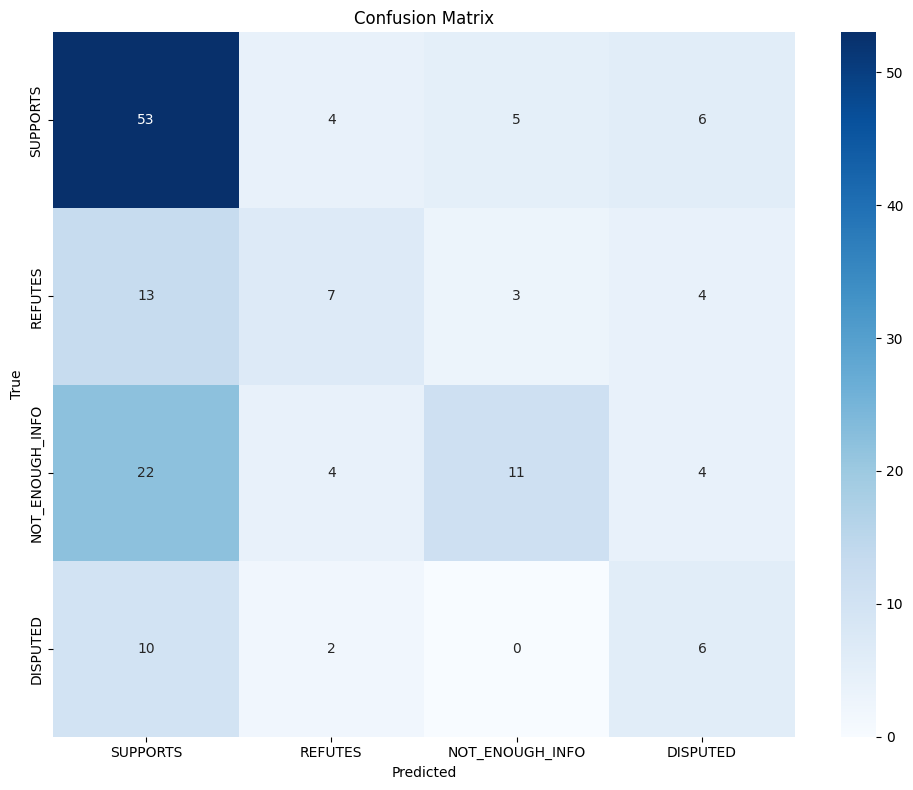


Task 2 completed!


In [14]:
def run_claim_verification(train_claims, dev_claims, test_claims, evidence, retriever=None):
    """
    Run the claim verification pipeline and generate predictions.
    """
    print("\n=== Claim Verification Hyperparameters ===")
    print(f"MODEL_NAME: {VERIFICATION_MODEL_NAME}")
    print(f"BATCH_SIZE: {VERIFICATION_BATCH_SIZE}")
    print(f"LEARNING_RATE: {VERIFICATION_LEARNING_RATE}")
    print(f"USE_CLASS_WEIGHTS: {USE_CLASS_WEIGHTS}")
    print(f"USE_MIXED_EVIDENCE: {USE_MIXED_EVIDENCE}")

    # Load retrieved evidence from Task 1
    dev_predictions = load_json(DEV_PREDICTIONS_PATH)
    test_predictions = load_json(TEST_PREDICTIONS_PATH)

    # Extract retrieved evidence
    dev_retrieved = {claim_id: data["evidences"] for claim_id, data in dev_predictions.items()}
    test_retrieved = {claim_id: data["evidences"] for claim_id, data in test_predictions.items()}

    # Check if retriever is valid
    if retriever is not None:
        print("Checking retriever functionality...")
        try:
            # Test retrieve method on a sample claim
            sample_claim_id = next(iter(train_claims))
            sample_claim_text = train_claims[sample_claim_id]["claim_text"]
            sample_evidence, _ = retriever.retrieve(sample_claim_text)
            print(f"Retriever test successful. Found {len(sample_evidence)} evidence passages.")
        except Exception as e:
            print(f"WARNING: Retriever test failed: {e}")

    # Train model
    model, stats = train_verification_model(
        train_claims=train_claims,
        dev_claims=dev_claims,
        evidence=evidence,
        retriever=retriever,
        use_mixed_evidence=USE_MIXED_EVIDENCE,
        use_class_weights=USE_CLASS_WEIGHTS
    )

    # Initialize tokenizer for predictions
    tokenizer = AutoTokenizer.from_pretrained(VERIFICATION_MODEL_NAME)

    # Make predictions on dev set
    print("\nMaking predictions on development set...")
    dev_pred_labels = predict_claims(model, dev_claims, evidence, dev_retrieved, tokenizer)

    # Evaluate dev predictions
    print("\nEvaluating development predictions:")
    dev_metrics = evaluate_predictions(dev_pred_labels, dev_claims)

    # Update dev predictions file
    update_predictions_file(DEV_PREDICTIONS_PATH, dev_pred_labels)

    # Make predictions on test set
    print("\nMaking predictions on test set...")
    test_pred_labels = predict_claims(model, test_claims, evidence, test_retrieved, tokenizer)

    # Update test predictions file
    update_predictions_file(TEST_PREDICTIONS_PATH, test_pred_labels)

    print("\nClaim verification completed!")
    return model, stats, dev_metrics

# Main execution - running task 2
if __name__ == "__main__":
    # Check if we already have retrieval results
    if 'retrieval_results' not in locals() and os.path.exists(os.path.join(DRIVE_DATA_PATH, 'retrieval_results.pt')):
        print("Loading saved retrieval results...")
        retrieval_results = torch.load(os.path.join(DRIVE_DATA_PATH, 'retrieval_results.pt'),weights_only=True)
    # Check if retriever is available
    if 'retrieval_results' in locals() and 'retriever' in retrieval_results:
        retriever = retrieval_results["retriever"]
        print("Found retriever in retrieval_results.")
    else:
        print("Retriever not found in retrieval_results.")
    print("\n=== Running Claim Verification (Task 2) ===")
    model, stats, metrics = run_claim_verification(
        train_claims=train_claims,
        dev_claims=dev_claims,
        test_claims=test_claims,
        evidence=evidence,
        retriever=retriever
    )

    # Visualize confusion matrix
    visualize_confusion_matrix(
        metrics["confusion_matrix"],
        list(LABEL_MAP.keys())
    )

    print("\nTask 2 completed!")

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*

#### Diagnose

In [15]:
def diagnose_dataset(train_claims, dev_claims, evidence):
    print("\n=== Dataset Diagnosis ===")

    # Check label distribution in claims
    train_labels = {}
    for claim_id, claim_data in train_claims.items():
        if "claim_label" in claim_data:
            label = claim_data["claim_label"]
            if label not in train_labels:
                train_labels[label] = 0
            train_labels[label] += 1

    print("\nLabel Distribution in Training Claims:")
    total_train = sum(train_labels.values())
    for label, count in train_labels.items():
        print(f"  {label}: {count} claims ({count/total_train*100:.2f}%)")

    # Check average number of evidence passages per claim
    train_evidence_counts = []
    for claim_id, claim_data in train_claims.items():
        if "evidences" in claim_data:
            train_evidence_counts.append(len(claim_data["evidences"]))

    print("\nEvidence per Claim in Training Set:")
    if train_evidence_counts:
        print(f"  Average: {np.mean(train_evidence_counts):.2f}")
        print(f"  Min: {min(train_evidence_counts)}")
        print(f"  Max: {max(train_evidence_counts)}")

    # Create a test dataset with the actual preprocessing
    tokenizer = AutoTokenizer.from_pretrained(VERIFICATION_MODEL_NAME)
    test_dataset = ClaimVerificationDataset(
        claims=train_claims,
        evidence=evidence,
        tokenizer=tokenizer,
        use_ground_truth=True,
        retrieved_evidence=None,
        mix_ratio=0.0
    )

    # Check processed sample distribution
    sample_labels = {}
    for sample in test_dataset.samples:
        label = sample["label"]
        if label not in sample_labels:
            sample_labels[label] = 0
        sample_labels[label] += 1

    print("\nLabel Distribution in Processed Samples:")
    total_samples = len(test_dataset.samples)
    for label, count in sample_labels.items():
        label_name = LABEL_MAP_REVERSE.get(label, f"Unknown ({label})")
        print(f"  {label_name}: {count} samples ({count/total_samples*100:.2f}%)")

    # Check for data processing issues by examining a few samples
    print("\nSample Check (first 3 samples):")
    for i in range(min(3, len(test_dataset))):
        sample = test_dataset[i]
        print(f"\nSample {i+1}:")
        print(f"  Label: {LABEL_MAP_REVERSE.get(sample['label'].item(), 'Unknown')}")

        # Decode the input IDs to check tokenization
        input_text = tokenizer.decode(sample["input_ids"])
        print(f"  Tokenized text (truncated): {input_text[:100]}...")

        # Check if special tokens are properly placed
        cls_token_id = tokenizer.cls_token_id
        sep_token_id = tokenizer.sep_token_id
        has_cls = sample["input_ids"][0] == cls_token_id
        has_sep = sep_token_id in sample["input_ids"]

        print(f"  Has CLS token at start: {has_cls}")
        print(f"  Has SEP token: {has_sep}")

        # Check attention mask
        valid_tokens = sum(sample["attention_mask"].tolist())
        print(f"  Valid tokens: {valid_tokens}/{len(sample['input_ids'])}")

    return test_dataset

In [16]:
def diagnose_model_predictions(model, test_dataset):
    print("\n=== Model Prediction Diagnosis ===")

    # Create a small subset of the dataset for quick testing
    subset_size = min(100, len(test_dataset))
    subset_indices = np.random.choice(len(test_dataset), subset_size, replace=False)

    # Create a dataloader for the subset
    batch_size = 16
    subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=subset_sampler)

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    # Get predictions
    with torch.no_grad():
        for batch in test_loader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass (handle models with and without token_type_ids)
            if 'token_type_ids' in batch and 'distilbert' not in VERIFICATION_MODEL_NAME.lower():
                _, logits = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    token_type_ids=batch["token_type_ids"],
                    labels=batch["label"]
                )
            else:
                _, logits = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["label"]
                )

            # Get predictions
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            labels = batch["label"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

            # Print some example predictions
            if len(all_preds) <= 5:  # Just show the first 5 examples
                for i in range(len(preds)):
                    print(f"\nPrediction example {len(all_preds) - len(preds) + i + 1}:")
                    print(f"  True label: {LABEL_MAP_REVERSE.get(labels[i], 'Unknown')}")
                    print(f"  Predicted: {LABEL_MAP_REVERSE.get(preds[i], 'Unknown')}")
                    print(f"  Probabilities: {probs[i].cpu().numpy().round(3)}")

    # Show prediction distribution
    pred_counts = {}
    for pred in all_preds:
        if pred not in pred_counts:
            pred_counts[pred] = 0
        pred_counts[pred] += 1

    print("\nPrediction Distribution:")
    for pred, count in pred_counts.items():
        pred_name = LABEL_MAP_REVERSE.get(pred, f"Unknown ({pred})")
        print(f"  {pred_name}: {count} predictions ({count/len(all_preds)*100:.2f}%)")

    # Show prediction vs actual distribution
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    labels = [LABEL_MAP_REVERSE.get(i, f"Unknown") for i in range(max(LABEL_MAP.values()) + 1)]

    # Print simple text version of confusion matrix
    print("True \\ Pred", end="")
    for label in labels:
        print(f" | {label[:3]}", end="")
    print()
    for i, label in enumerate(labels):
        print(f"{label[:7]}", end="")
        for j in range(len(labels)):
            if i < cm.shape[0] and j < cm.shape[1]:
                print(f" | {cm[i, j]:3d}", end="")
            else:
                print(" |   0", end="")
        print()

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy on subset: {accuracy:.4f}")

    return all_preds, all_labels

In [17]:
def diagnose_gradient_flow(model, test_dataset):
    print("\n=== Gradient Flow Diagnosis ===")

    # Create a small subset of the dataset for quick testing
    subset_size = min(32, len(test_dataset))
    subset_indices = np.random.choice(len(test_dataset), subset_size, replace=False)

    # Create a dataloader for the subset
    batch_size = 16
    subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=subset_sampler)

    # Move model to device and set to training mode
    model.to(device)
    model.train()

    # Create optimizer
    optimizer = optim.AdamW(model.parameters(), lr=VERIFICATION_LEARNING_RATE)

    # Get a batch
    batch = next(iter(test_loader))
    batch = {k: v.to(device) for k, v in batch.items()}

    # Record initial parameter values
    initial_params = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            initial_params[name] = param.clone().detach().cpu().numpy()
            print(f"  {name}: shape={param.shape}, mean={param.data.mean().item():.6f}, std={param.data.std().item():.6f}")

    # Forward pass
    optimizer.zero_grad()

    if 'token_type_ids' in batch and 'distilbert' not in VERIFICATION_MODEL_NAME.lower():
        loss, logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],
            labels=batch["label"]
        )
    else:
        loss, logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )

    print(f"\nLoss: {loss.item():.4f}")

    # Backward pass
    loss.backward()

    # Check gradients
    print("\nGradient Magnitudes:")
    zero_grad_params = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is None:
                zero_grad_params.append(name)
                print(f"  {name}: NO GRADIENT")
            else:
                grad_mean = param.grad.abs().mean().item()
                grad_max = param.grad.abs().max().item()
                print(f"  {name}: mean={grad_mean:.6f}, max={grad_max:.6f}")

    if zero_grad_params:
        print(f"\nWARNING: {len(zero_grad_params)} parameters have no gradient!")

    # Apply gradients
    optimizer.step()

    # Check parameter changes
    print("\nParameter Changes After One Update:")
    unchanged_params = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            new_value = param.clone().detach().cpu().numpy()
            old_value = initial_params[name]

            # Calculate relative change
            abs_diff = np.abs(new_value - old_value)
            rel_change = np.mean(abs_diff) / (np.mean(np.abs(old_value)) + 1e-9)

            change_description = f"  {name}: relative change={rel_change:.6f}"

            if rel_change == 0:
                unchanged_params.append(name)
                change_description += " (NO CHANGE)"

            print(change_description)

    if unchanged_params:
        print(f"\nWARNING: {len(unchanged_params)} parameters did not change after update!")

    return not (zero_grad_params or unchanged_params)

In [18]:
def diagnose_mixed_evidence(train_claims, evidence, retriever):
    print("\n=== Mixed Evidence Diagnosis ===")

    if retriever is None:
        print("No retriever provided. Cannot diagnose mixed evidence functionality.")
        return False

    # Test retrieval for a few claims
    sample_size = 5
    sample_claims = dict(list(train_claims.items())[:sample_size])

    print(f"Testing retrieval for {sample_size} sample claims...")

    for claim_id, claim_data in sample_claims.items():
        print(f"\nClaim: {claim_data['claim_text']}")

        # Get ground truth evidence
        if "evidences" in claim_data:
            ground_truth = claim_data["evidences"]
            print(f"Ground truth evidence count: {len(ground_truth)}")

            # Show first ground truth evidence
            if ground_truth:
                first_evidence_id = ground_truth[0]
                if first_evidence_id in evidence:
                    print(f"Ground truth evidence sample: {evidence[first_evidence_id][:100]}...")

        # Retrieve evidence using retriever
        try:
            claim_text = claim_data["claim_text"]
            retrieved_evidence, scores = retriever.retrieve(claim_text)
            print(f"Retrieved evidence count: {len(retrieved_evidence)}")

            # Show first retrieved evidence
            if retrieved_evidence:
                first_retrieved_id = retrieved_evidence[0]
                if first_retrieved_id in evidence:
                    print(f"Retrieved evidence sample: {evidence[first_retrieved_id][:100]}...")
                    print(f"Retrieval score: {scores[0]:.4f}")

            # Check overlap with ground truth
            if "evidences" in claim_data:
                overlap = set(retrieved_evidence).intersection(set(ground_truth))
                print(f"Overlap with ground truth: {len(overlap)}/{len(ground_truth)}")
        except Exception as e:
            print(f"Error during retrieval: {e}")
            return False

    # Create datasets with and without mixed evidence
    tokenizer = AutoTokenizer.from_pretrained(VERIFICATION_MODEL_NAME)

    # Ground truth only dataset
    gt_dataset = ClaimVerificationDataset(
        claims=sample_claims,
        evidence=evidence,
        tokenizer=tokenizer,
        use_ground_truth=True,
        retrieved_evidence=None,
        mix_ratio=0.0
    )

    # Get retrieved evidence for sample claims
    retrieved_evidence_dict = {}
    for claim_id, claim_data in sample_claims.items():
        claim_text = claim_data["claim_text"]
        evidence_ids, _ = retriever.retrieve(claim_text)
        retrieved_evidence_dict[claim_id] = evidence_ids

    # Mixed evidence dataset
    mixed_dataset = ClaimVerificationDataset(
        claims=sample_claims,
        evidence=evidence,
        tokenizer=tokenizer,
        use_ground_truth=True,
        retrieved_evidence=retrieved_evidence_dict,
        mix_ratio=0.5
    )

    print(f"\nGround truth only dataset size: {len(gt_dataset)}")
    print(f"Mixed evidence dataset size: {len(mixed_dataset)}")

    # Check if mixed dataset is actually larger
    is_working = len(mixed_dataset) > len(gt_dataset)
    print(f"Mixed evidence functionality is {'working' if is_working else 'NOT working properly'}")

    return is_working

#### Diagnose Main

In [19]:
# def run_full_diagnosis(train_claims, dev_claims, evidence, retriever=None):
#     """
#     Run a full suite of diagnostic tests to identify model issues.
#     """
#     print("\n=== STARTING FULL DIAGNOSTIC TESTS ===\n")

#     # Step 1: Diagnose the dataset
#     test_dataset = diagnose_dataset(train_claims, dev_claims, evidence)

#     # Step 2: Create and diagnose a new model
#     print("\nInitializing a fresh model for testing...")
#     model = ClaimVerificationModel(num_labels=VERIFICATION_NUM_LABELS, model_name=VERIFICATION_MODEL_NAME)
#     model.to(device)

#     # Step 3: Check gradient flow
#     gradient_flows = diagnose_gradient_flow(model, test_dataset)

#     # Step 4: Train for one epoch to capture initial predictions
#     print("\nTraining for one epoch to check initial learning...")
#     optimizer = optim.AdamW(model.parameters(), lr=VERIFICATION_LEARNING_RATE)
#     train_loader = DataLoader(test_dataset, batch_size=VERIFICATION_BATCH_SIZE, shuffle=True)

#     model.train()
#     avg_loss = 0
#     for batch in tqdm(train_loader, desc="Training"):
#         batch = {k: v.to(device) for k, v in batch.items()}

#         optimizer.zero_grad()
#         if 'token_type_ids' in batch and 'distilbert' not in VERIFICATION_MODEL_NAME.lower():
#             loss, _ = model(
#                 input_ids=batch["input_ids"],
#                 attention_mask=batch["attention_mask"],
#                 token_type_ids=batch["token_type_ids"],
#                 labels=batch["label"]
#             )
#         else:
#             loss, _ = model(
#                 input_ids=batch["input_ids"],
#                 attention_mask=batch["attention_mask"],
#                 labels=batch["label"]
#             )

#         loss.backward()
#         optimizer.step()
#         avg_loss += loss.item()

#     avg_loss /= len(train_loader)
#     print(f"Average loss after one epoch: {avg_loss:.4f}")

#     # Step 5: Check model predictions
#     all_preds, all_labels = diagnose_model_predictions(model, test_dataset)

#     # Step 6: Check mixed evidence functionality if retriever is available
#     if retriever is not None:
#         mixed_evidence_works = diagnose_mixed_evidence(train_claims, evidence, retriever)
#     else:
#         print("\nSkipping mixed evidence diagnosis (no retriever provided)")
#         mixed_evidence_works = None

#     # Summarize findings
#     print("\n=== DIAGNOSTIC SUMMARY ===")

#     # Check for dataset imbalance
#     label_counts = {}
#     for label in all_labels:
#         if label not in label_counts:
#             label_counts[label] = 0
#         label_counts[label] += 1

#     most_common_label = max(label_counts.items(), key=lambda x: x[1])[0]
#     most_common_pct = label_counts[most_common_label] / len(all_labels) * 100

#     if most_common_pct > 50:
#         print(f"✘ Dataset imbalance detected: {LABEL_MAP_REVERSE.get(most_common_label)} class dominates ({most_common_pct:.1f}%)")
#     else:
#         print(f"✓ Dataset balance looks reasonable (largest class: {most_common_pct:.1f}%)")

#     # Check for prediction uniformity
#     pred_counts = {}
#     for pred in all_preds:
#         if pred not in pred_counts:
#             pred_counts[pred] = 0
#         pred_counts[pred] += 1

#     if len(pred_counts) < len(LABEL_MAP):
#         print(f"✘ Model is not predicting all classes (only {len(pred_counts)} out of {len(LABEL_MAP)})")
#     else:
#         print(f"✓ Model is predicting all {len(LABEL_MAP)} classes")

#     most_common_pred = max(pred_counts.items(), key=lambda x: x[1])[0]
#     most_common_pred_pct = pred_counts[most_common_pred] / len(all_preds) * 100

#     if most_common_pred_pct > 70:
#         print(f"✘ Model is biased toward {LABEL_MAP_REVERSE.get(most_common_pred)} class ({most_common_pred_pct:.1f}%)")
#     else:
#         print(f"✓ Model prediction distribution looks reasonable")

#     # Check gradient flow
#     if gradient_flows:
#         print("✓ Gradient flow is working correctly")
#     else:
#         print("✘ Gradient flow issues detected")

#     # Check mixed evidence
#     if mixed_evidence_works is not None:
#         if mixed_evidence_works:
#             print("✓ Mixed evidence functionality is working correctly")
#         else:
#             print("✘ Mixed evidence functionality is NOT working properly")

#     print("\n=== END OF DIAGNOSIS ===")

#     return {
#         "dataset_imbalance": most_common_pct > 50,
#         "prediction_bias": most_common_pred_pct > 70,
#         "gradient_flow_issues": not gradient_flows,
#         "mixed_evidence_issues": False if mixed_evidence_works else True
#     }

In [20]:
# Run diagnostic tests
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    # Run full diagnosis
    if 'retrieval_results' not in locals() and os.path.exists(os.path.join(DRIVE_DATA_PATH, 'retrieval_results.pt')):
        print("Loading saved retrieval results...")
        retrieval_results = torch.load(os.path.join(DRIVE_DATA_PATH, 'retrieval_results.pt'),weights_only=True)
        retriever = retrieval_results.get("retriever") if "retriever" in retrieval_results else None
    else:
        retriever = None

    diagnosis_results = run_full_diagnosis(train_claims, dev_claims, evidence, retriever)

    # Based on diagnosis, suggest fixes
    print("\n=== RECOMMENDED FIXES ===")

    if diagnosis_results["dataset_imbalance"]:
        print("1. Apply class weighting by setting USE_CLASS_WEIGHTS = True")
        print("2. Consider oversampling minority classes or downsampling majority classes")

    if diagnosis_results["prediction_bias"]:
        print("1. Reduce learning rate (try 5e-6 instead of 2e-5)")
        print("2. Train for more epochs (5-10 instead of 3)")
        print("3. Consider using focal loss instead of cross-entropy loss")

    if diagnosis_results["gradient_flow_issues"]:
        print("1. Check for NaN values in inputs or gradients")
        print("2. Reduce batch size if you're encountering memory issues")
        print("3. Consider gradient clipping to prevent exploding gradients")

    if diagnosis_results["mixed_evidence_issues"]:
        print("1. Fix the mixed evidence implementation")
        print("2. Check the retriever functionality")
        print("3. Ensure the mix_ratio is properly used in the dataset creation")

NameError: name 'run_full_diagnosis' is not defined